In [1]:
!nvidia-smi

Tue Jan 18 06:46:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install fastai

In [1]:
from fastai.vision import *
from fastai.metrics import error_rate, accuracy
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Set path to root directory
path = Path('/content/drive/MyDrive/damage_assess_sahaj/front_rear_side')
# View all files in directory
path.ls()

[PosixPath('/content/drive/MyDrive/damage_assess_sahaj/front_rear_side/.DS_Store'),
 PosixPath('/content/drive/MyDrive/damage_assess_sahaj/front_rear_side/test'),
 PosixPath('/content/drive/MyDrive/damage_assess_sahaj/front_rear_side/train'),
 PosixPath('/content/drive/MyDrive/damage_assess_sahaj/front_rear_side/val'),
 PosixPath('/content/drive/MyDrive/damage_assess_sahaj/front_rear_side/models')]

In [3]:
#data preprocessing
data = ImageDataBunch.from_folder(path, train='train', valid='val', ds_tfms=get_transforms(do_flip=False), size=224, bs=64, num_workers=8)

In [4]:
# Show what the data looks like after being transformed
data.show_batch()

Output hidden; open in https://colab.research.google.com to view.

In [5]:
# See the classes and count of classes in your dataset
print(data.classes,data.c)


['front', 'rear', 'side'] 3


In [6]:
# See the number of images in each data set
print(len(data.train_ds), len(data.valid_ds))

875 108


In [7]:
# Build the CNN model with the pretrained resnet34
# Error rate = 1 - accuracy
learn = cnn_learner(data, models.densenet201, metrics = [accuracy , FBeta(), Precision(), Recall()])
# Train the model on 4 epochs of data at the default learning rate
learn.fit_one_cycle(6)

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


  0%|          | 0.00/77.4M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,f_beta,precision,recall,time
0,1.665625,0.890022,0.638889,0.644954,0.645602,0.653872,01:24
1,1.336619,0.978590,0.703704,0.705119,0.698733,0.706734,00:10
2,1.045227,0.904648,0.712963,0.707567,0.704185,0.708418,00:10
3,0.851781,0.780298,0.722222,0.718112,0.720539,0.717508,00:10
4,0.691976,0.727060,0.740741,0.737926,0.738791,0.737710,00:10
5,0.580144,0.698714,0.777778,0.774031,0.775209,0.773737,00:10


In [8]:
# Save the model
learn.save('stage-1')
# Load the Model
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (875 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
side,side,side,side,side
Path: /content/drive/MyDrive/damage_assess_sahaj/front_rear_side;

Valid: LabelList (108 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
rear,rear,rear,rear,rear
Path: /content/drive/MyDrive/damage_assess_sahaj/front_rear_side;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 4.79E-05


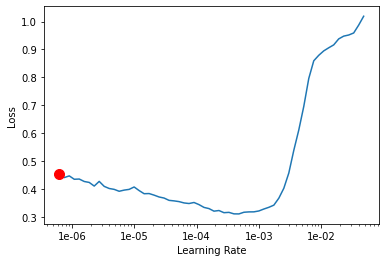

In [9]:
#finding optimum learning rate
# Unfreeze all layers of the CNN
learn.unfreeze()
# Find the optimal learning rate and plot a visual
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [10]:
# Fit the model over 2 epochs
learn.fit_one_cycle(4, max_lr=slice(3e-7, 3e-6))

epoch,train_loss,valid_loss,accuracy,f_beta,precision,recall,time
0,0.328838,0.672731,0.777778,0.774629,0.775190,0.774748,00:12
1,0.343044,0.686192,0.777778,0.775758,0.775758,0.775758,00:11
2,0.332965,0.683207,0.787037,0.783488,0.784783,0.783165,00:12
3,0.349160,0.684843,0.777778,0.773727,0.776390,0.773064,00:12


In [11]:
# Fit the model over 2 epochs
learn.fit_one_cycle(10, max_lr=slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,accuracy,f_beta,precision,recall,time
0,0.288657,0.622882,0.796296,0.792086,0.801130,0.791583,00:12
1,0.247694,0.496290,0.861111,0.860879,0.866049,0.859596,00:12
2,0.241300,0.872175,0.787037,0.783810,0.808903,0.777778,00:12
3,0.244657,0.952139,0.759259,0.766619,0.773232,0.764983,00:12
4,0.238928,0.665719,0.851852,0.857991,0.859658,0.857576,00:12
5,0.219245,0.612155,0.879630,0.880650,0.880019,0.880808,00:12
6,0.185189,0.569823,0.870370,0.874412,0.874414,0.874411,00:12
7,0.156251,0.543026,0.870370,0.871717,0.871717,0.871717,00:12
8,0.129251,0.519739,0.870370,0.871717,0.871717,0.871717,00:12
9,0.106902,0.521304,0.879630,0.882164,0.883547,0.881818,00:12


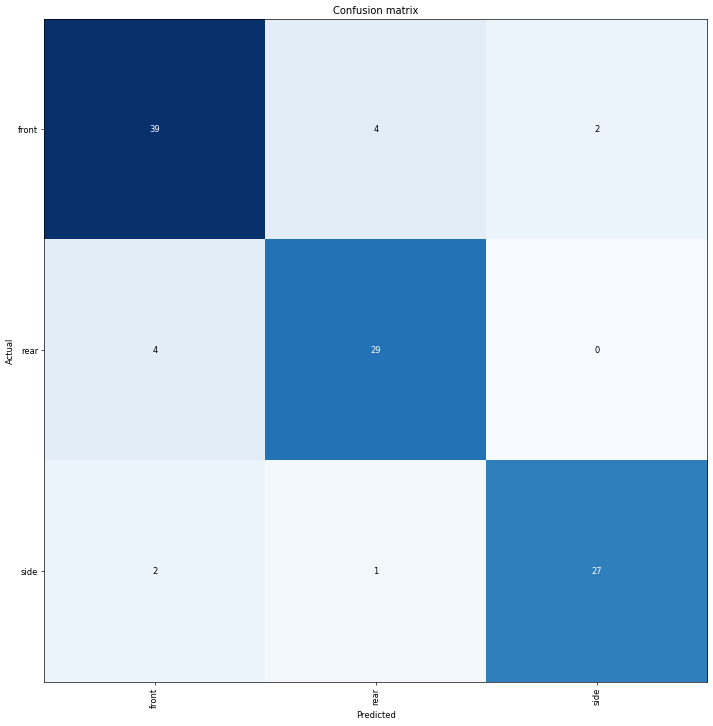

In [12]:
# Rebuild interpreter and replot confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [13]:
#text version of cm
interp.most_confused(min_val=2)

[('front', 'rear', 4),
 ('rear', 'front', 4),
 ('front', 'side', 2),
 ('side', 'front', 2)]

In [16]:
# Save the model
learn.save('stage-2')

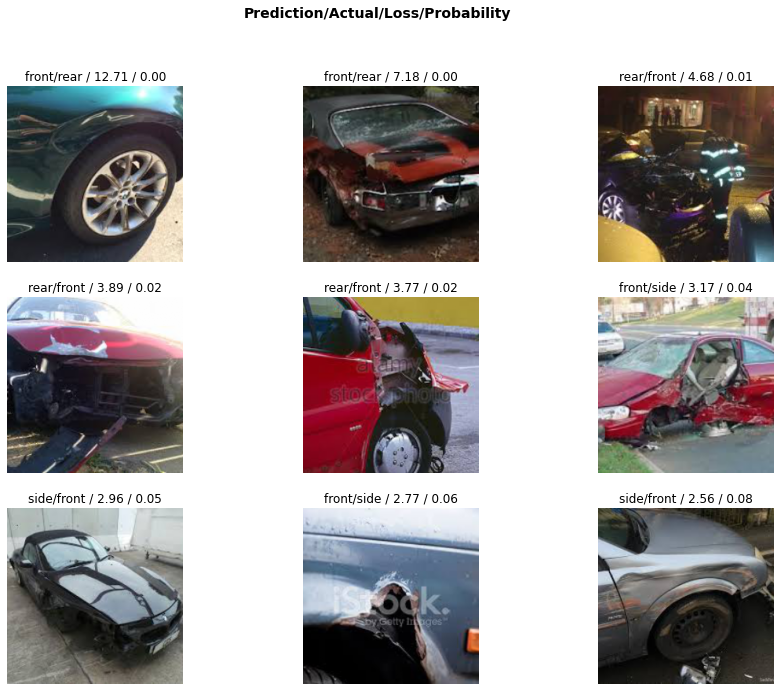

In [15]:
# Show top 9 images with the highest loss
interp.plot_top_losses(9, figsize=(15,11))